In [1]:
import generate_masterdf as gm
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from scipy.stats import sem
from generate_plots import subject_wise_error_plot, quick_visualization, distribution_plots
from helpers import variance_error_summary
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)
sns.set()

We have 1 subjects so far: ['sub01']

Creating a new dataframe.
Running subj = 1, day = 1
Trial-count: pro = 200, anti = 200

Running subj = 1, day = 2
Trial-count: pro = 200, anti = 200

Running subj = 1, day = 3
Trial-count: pro = 200, anti = 200



In [2]:
df = gm.master_df
#df = variance_error_summary(df)
print('Dataframe description')
df.info()

Dataframe description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subjID               1200 non-null   int64  
 1   day                  1200 non-null   int64  
 2   tnum                 1200 non-null   uint8  
 3   rnum                 1200 non-null   uint8  
 4   istms                1200 non-null   uint8  
 5   ispro                1200 non-null   uint8  
 6   instimVF             1200 non-null   uint8  
 7   bad_drift_correct    1200 non-null   uint8  
 8   bad_calibration      1200 non-null   uint8  
 9   breakfix             1200 non-null   uint8  
 10  no_prim_sacc         1200 non-null   uint8  
 11  small_sacc           1200 non-null   uint8  
 12  large_error          1200 non-null   uint8  
 13  rejtrials            1200 non-null   uint8  
 14  TarX                 1200 non-null   float64
 15  TarY            

In [3]:
df.describe()
df.describe(include=object)

,trial_type,TMS_condition
count,1200,1200
unique,4,3
top,pro_intoVF,TMS intoVF
freq,300,400


In [4]:
n_rows_original = len(df)
# Filter out entries with 'rejtrials' == 1
df_filtered = df[(df['rejtrials'] != 1) & (df['isacc_err'])].copy()
df_filtered = df_filtered.dropna()
n_rows_filtered = len(df_filtered)
print(f"Original = {n_rows_original}, after filtering = {n_rows_filtered} trials.")
print()
print('Dataframe description after filtering')
df_filtered.info()

Original = 1200, after filtering = 1186 trials.

Dataframe description after filtering
<class 'pandas.core.frame.DataFrame'>
Index: 1186 entries, 0 to 1199
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subjID               1186 non-null   int64  
 1   day                  1186 non-null   int64  
 2   tnum                 1186 non-null   uint8  
 3   rnum                 1186 non-null   uint8  
 4   istms                1186 non-null   uint8  
 5   ispro                1186 non-null   uint8  
 6   instimVF             1186 non-null   uint8  
 7   bad_drift_correct    1186 non-null   uint8  
 8   bad_calibration      1186 non-null   uint8  
 9   breakfix             1186 non-null   uint8  
 10  no_prim_sacc         1186 non-null   uint8  
 11  small_sacc           1186 non-null   uint8  
 12  large_error          1186 non-null   uint8  
 13  rejtrials            1186 non-null   uint8  
 14  TarX  

In [5]:
df_filtered.head(50)

,subjID,day,tnum,rnum,istms,ispro,instimVF,bad_drift_correct,bad_calibration,breakfix,no_prim_sacc,small_sacc,large_error,rejtrials,TarX,TarY,isaccX,isaccY,fsaccX,fsaccY,isacc_err,fsacc_err,nsacc,calib_err,isacc_rt,fsacc_rt,isacc_peakvel,fsacc_peakvel,trial_type,TMS_condition,TarRadius,TarTheta,TarX_rotated,TarY_rotated,isaccRadius,isaccTheta,isaccX_rotated,isaccY_rotated,fsaccRadius,fsaccTheta,fsaccX_rotated,fsaccY_rotated,TarRadius_rotated,TarTheta_rotated,isaccRadius_rotated,isaccTheta_rotated,fsaccRadius_rotated,fsaccTheta_rotated
0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,13.1288,-0.9909,14.6400,-0.7478,12.9286,-1.0299,1.5306e+00,2.0401e-01,2,0.3699,0.324,0.371,515.8000,97.2753,pro_intoVF,TMS intoVF,13.1662,-0.0753,13.1305,0.9681,14.6591,-0.0510,14.5889,1.4327,12.9696,-0.0795,12.9383,0.8998,13.1662,3.2152,14.6591,3.2395,12.9696,3.2110
1,1,1,2,1,1,1,1,0,0,0,0,0,0,0,14.8078,-2.7249,14.5900,-3.1038,14.5900,-3.1038,4.3707e-01,4.3707e-01,1,0.4148,0.388,0.388,541.2761,541.2761,pro_intoVF,TMS intoVF,15.0564,-0.1820,15.0482,-0.4976,14.9164,-0.2096,14.8890,-0.9046,14.9164,-0.2096,14.8890,-0.9046,15.0564,3.1085,14.9164,3.0809,14.9164,3.0809
2,1,1,3,1,1,1,0,0,1,0,0,0,0,0,-13.4591,-0.1101,-14.1817,-0.3972,-14.1817,-0.3972,7.7753e-01,7.7753e-01,1,13.3926,0.237,0.237,454.7722,454.7722,pro_outVF,TMS outVF,13.4596,-3.1334,13.3265,-1.8881,14.1873,-3.1136,14.0837,-1.7114,14.1873,-3.1136,14.0837,-1.7114,13.4596,3.0008,14.1873,3.0207,14.1873,3.0207
3,1,1,4,1,1,1,0,0,0,0,0,0,0,0,-14.4775,-1.1835,-15.1535,-1.1762,-15.1535,-1.1762,6.7608e-01,6.7608e-01,1,0.2299,0.239,0.239,466.0982,466.0982,pro_outVF,TMS outVF,14.5258,-3.0600,14.4929,-0.9777,15.1991,-3.0641,15.1603,-1.0853,15.1991,-3.0641,15.1603,-1.0853,14.5258,3.0742,15.1991,3.0701,15.1991,3.0701
4,1,1,5,1,1,1,1,0,0,0,0,0,0,0,14.4775,-1.1835,11.5502,-0.6175,11.5502,-0.6175,2.9815e+00,2.9815e+00,1,0.1549,0.302,0.302,462.1429,462.1429,pro_intoVF,TMS intoVF,14.5258,-0.0816,14.4929,0.9777,11.5667,-0.0534,11.5140,1.1031,11.5667,-0.0534,11.5140,1.1031,14.5258,3.2090,11.5667,3.2371,11.5667,3.2371
5,1,1,6,1,1,1,1,0,0,0,0,0,0,0,14.4225,-2.3120,15.1806,-2.1373,14.4225,-2.3120,7.7800e-01,5.3475e-15,2,1.7495,0.293,0.350,544.3964,51.9213,pro_intoVF,TMS intoVF,14.6066,-0.1590,14.6059,-0.1465,15.3303,-0.1399,15.3297,0.1388,14.6066,-0.1590,14.6059,-0.1465,14.6066,3.1316,15.3303,3.1506,14.6066,3.1316
6,1,1,7,1,1,1,0,0,0,0,0,0,0,0,-13.8445,-1.9267,-14.3968,-1.2323,-14.3968,-1.2323,8.8726e-01,8.8726e-01,1,0.2978,0.358,0.358,452.0329,452.0329,pro_outVF,TMS outVF,13.9779,-3.0033,13.9771,-0.1489,14.4494,-3.0562,14.4203,-0.9175,14.4494,-3.0562,14.4203,-0.9175,13.9779,3.1309,14.4494,3.0781,14.4494,3.0781
7,1,1,8,1,1,1,0,0,0,0,0,0,0,0,-14.7527,-2.6698,-13.9612,-4.0365,-13.9612,-4.0365,1.5794e+00,1.5794e+00,1,0.1543,0.345,0.345,493.0163,493.0163,pro_outVF,TMS outVF,14.9924,-2.9626,14.9856,0.4513,14.5330,-2.8601,14.4056,1.9203,14.5330,-2.8601,14.4056,1.9203,14.9924,3.1717,14.5330,3.2741,14.5330,3.2741
8,1,1,9,1,1,1,1,0,0,0,0,0,0,0,14.5050,-3.4405,14.0122,-3.3583,14.0122,-3.3583,4.9961e-01,4.9961e-01,1,0.1056,0.248,0.248,514.1623,514.1623,pro_intoVF,TMS intoVF,14.9075,-0.2329,14.8550,-1.2502,14.4090,-0.2352,14.3554,-1.2421,14.4090,-0.2352,14.3554,-1.2421,14.9075,3.0576,14.4090,3.0553,14.4090,3.0553
9,1,1,10,1,1,1,0,0,0,1,0,0,0,0,-13.1564,-1.0734,-13.1564,-1.0734,-13.1564,-1.0734,5.5228e-14,5.5228e-14,1,0.6430,0.238,0.238,440.4480,440.4480,pro_outVF,TMS outVF,13.2001,-3.0602,13.1700,-0.8906,13.2001,-3.0602,13.1700,-0.8906,13.2001,-3.0602,13.1700,-0.8906,13.2001,3.0741,13.2001,3.0741,13.2001,3.0741


## Learning Curve

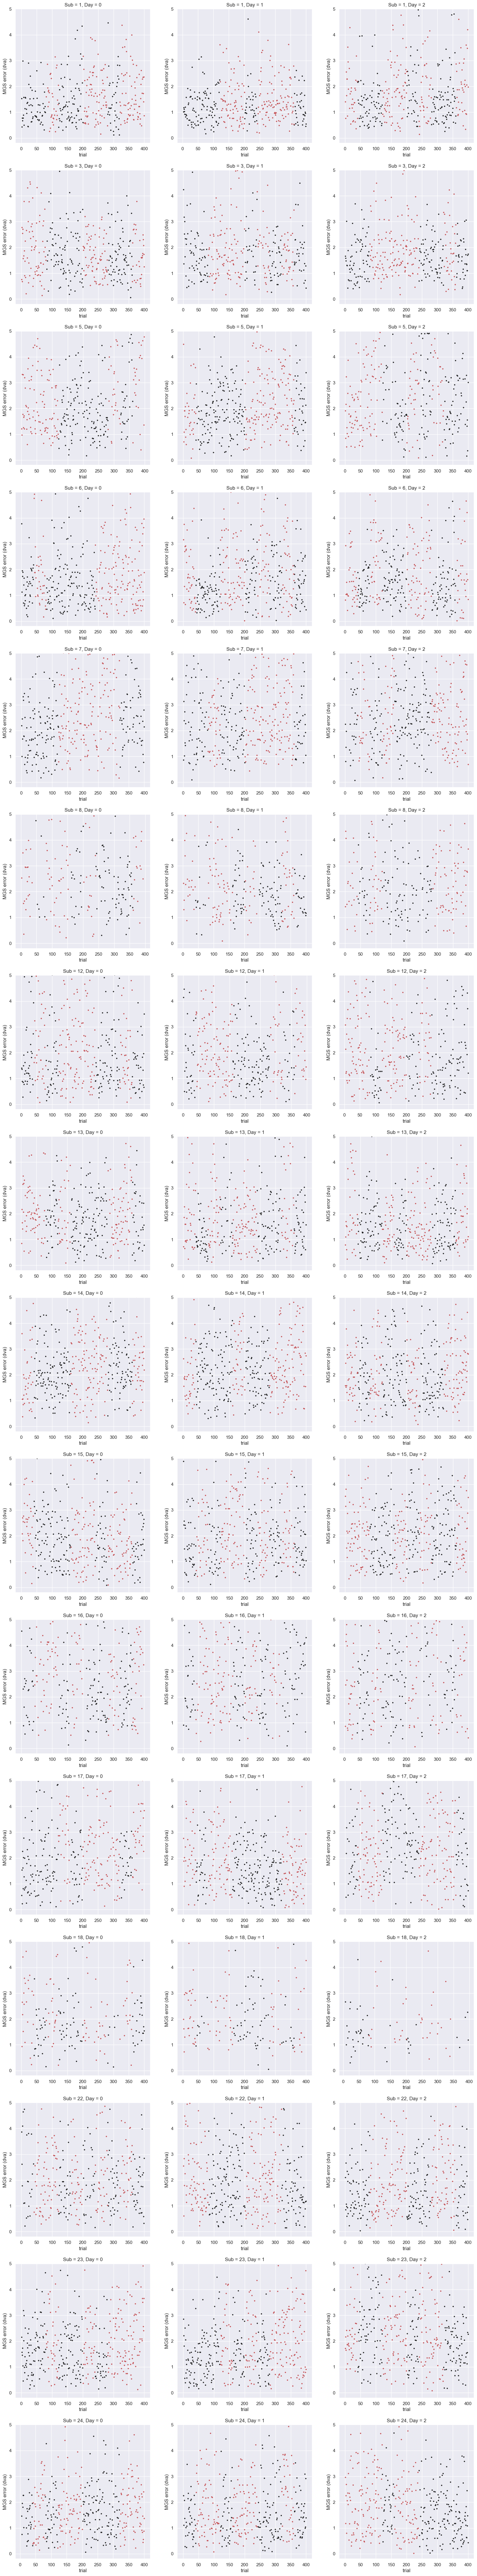

In [128]:
save_folder = '/datc/MD_TMS_EEG/Figures/'
sub_list = np.unique(df_filtered['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 3, figsize = (20, 7*len(sub_list)))
#plt.suptitle('Learning curve')
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    for day in range(3):
        df_today_pro = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['day'] == day+1) & (df_filtered['ispro'] == 1)]
        df_today_anti = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['day'] == day+1) & (df_filtered['ispro'] == 0)]
        this_tr_num_pro = ((df_today_pro['rnum'] - 1) * 40 + df_today_pro['tnum'])
        this_tr_num_anti = ((df_today_anti['rnum'] - 1) * 40 + df_today_anti['tnum'])
        axs[sub, day].plot(this_tr_num_pro, df_today_pro['isacc_err'], 'ko', markersize = 2)
        axs[sub, day].plot(this_tr_num_anti, df_today_anti['isacc_err'], 'ro', markersize = 2)
        axs[sub, day].set_xlabel('trial')
        axs[sub, day].set_ylabel('MGS error (dva)')
        axs[sub, day].set_title('Sub = ' + str(this_sub) + ', Day = ' + str(day))
        axs[sub, day].set_ylim([-0.2, 5])
plt.savefig(save_folder + 'learning_curve.pdf', format="pdf", bbox_inches="tight")
plt.show()

        

## Did subjects use semantic knowledge of target location?

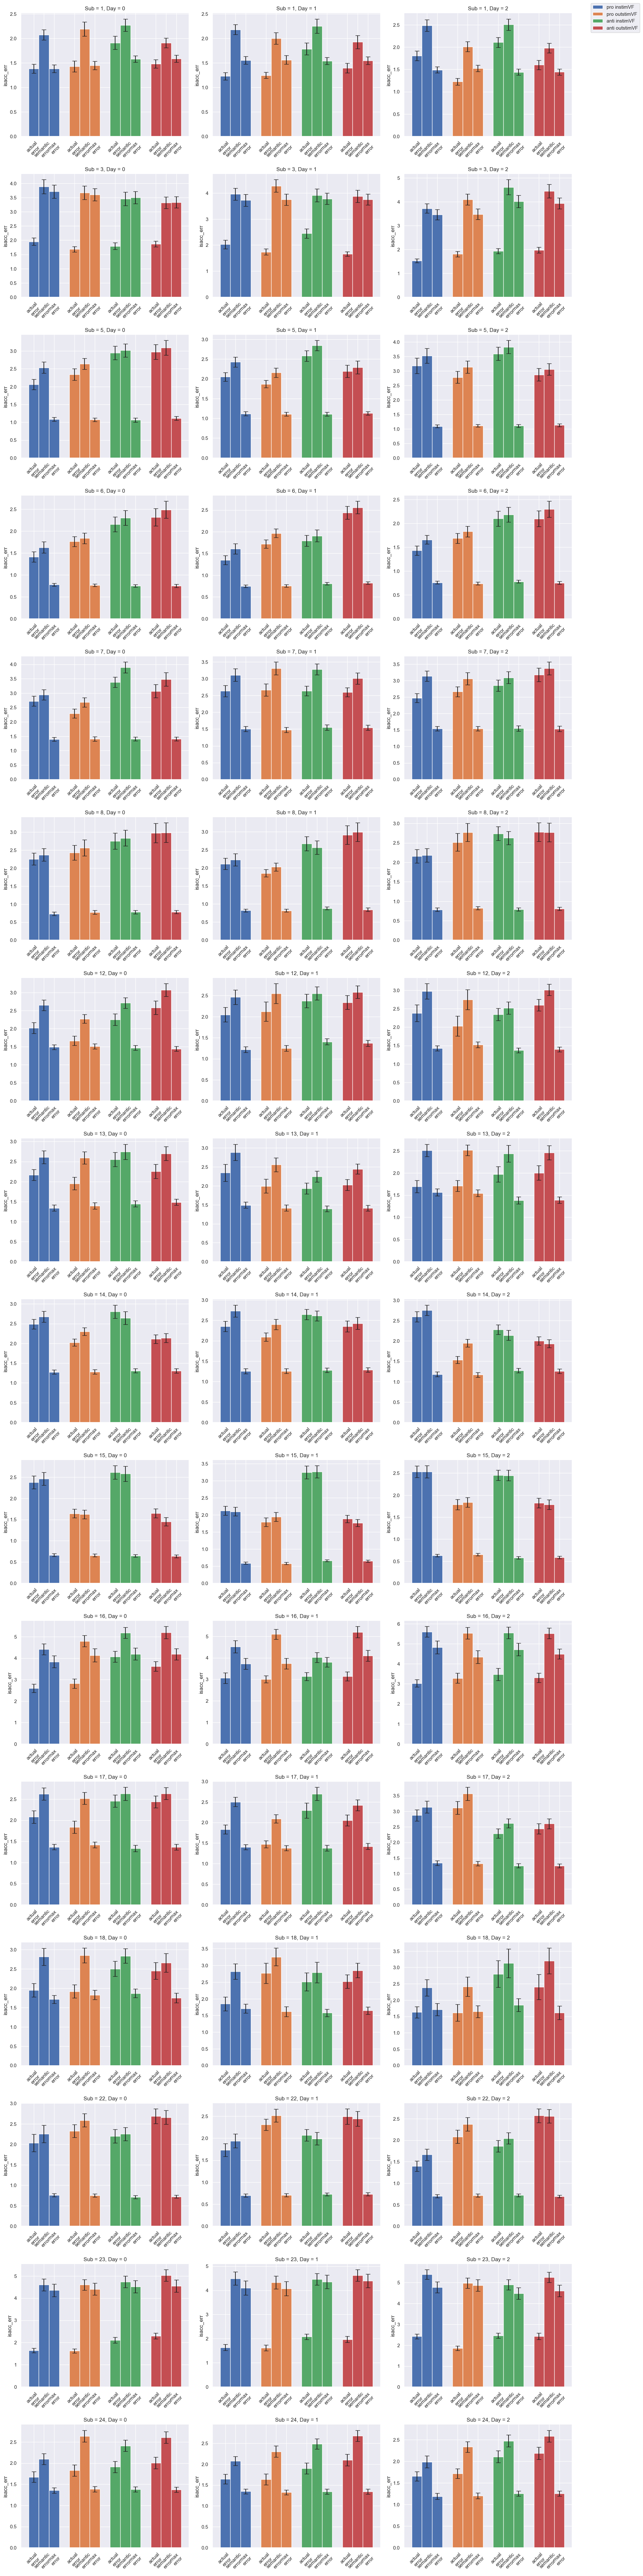

In [154]:
sub_list = np.unique(df_filtered['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 3, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror',
          'actual\nerror', 'semantic\nerror', 'max\nerror', 'actual\nerror', 'semantic\nerror', 'max\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    for day in range(3):
        df_pro_instimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['day'] == day+1) & (df_filtered['ispro'] == 1) & (df_filtered['instimVF'] == 1)]
        df_pro_outstimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['day'] == day+1) & (df_filtered['ispro'] == 1) & (df_filtered['instimVF'] == 0)]
        df_anti_instimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['day'] == day+1) & (df_filtered['ispro'] == 0) & (df_filtered['instimVF'] == 1)]
        df_anti_outstimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['day'] == day+1) & (df_filtered['ispro'] == 0) & (df_filtered['instimVF'] == 0)]
        
        tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
        tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
        tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
        tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
        
        Xpi_sem = np.median(df_pro_instimVF['TarX'])
        Ypi_sem = np.median(df_pro_instimVF['TarY'])
        Xpo_sem = np.median(df_pro_outstimVF['TarX'])
        Ypo_sem = np.median(df_pro_outstimVF['TarY'])
        Xai_sem = np.median(df_anti_instimVF['TarX'])
        Yai_sem = np.median(df_anti_instimVF['TarY'])
        Xao_sem = np.median(df_anti_outstimVF['TarX'])
        Yao_sem = np.median(df_anti_outstimVF['TarY'])

        errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
        errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
        errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
        errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
        
        tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
        tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
        tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
        tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
        

        errpi = df_pro_instimVF['isacc_err']
        errpo = df_pro_outstimVF['isacc_err']
        errai = df_anti_instimVF['isacc_err']
        errao = df_anti_outstimVF['isacc_err']
        
        
        pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
        po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
        ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
        ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
        pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
        po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
        ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
        ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
        
        bar1 = axs[sub, day].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
        bar2 = axs[sub, day].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
        bar3 = axs[sub, day].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
        bar4 = axs[sub, day].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
        legend_handles.extend([bar1, bar2, bar3, bar4])
        axs[sub, day].set_ylabel('isacc_err')
        axs[sub, day].set_title('Sub = ' + str(this_sub) + ', Day = ' + str(day))
        axs[sub, day].set_xticks(x)
        axs[sub, day].set_xticklabels(labels, rotation = 45)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy.pdf', format="pdf", bbox_inches="tight")
plt.show()

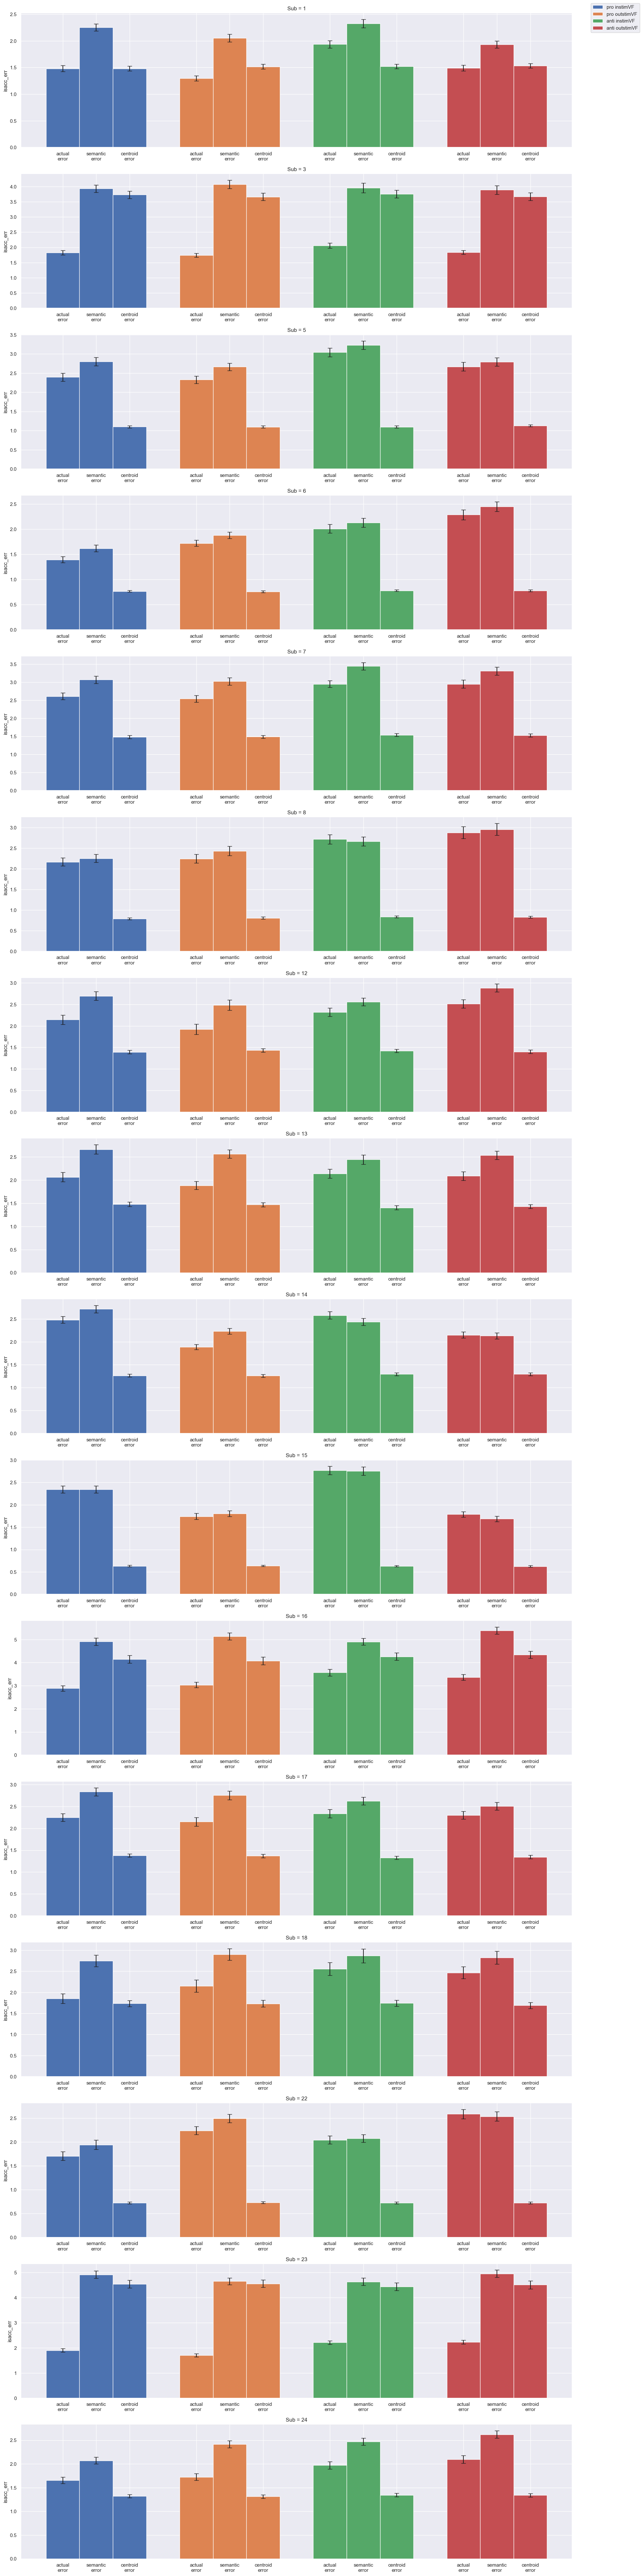

In [156]:
sub_list = np.unique(df_filtered['subjID'].values)
#sub_list = [1, 3]
fig, axs = plt.subplots(len(sub_list), 1, figsize = (20, 5*len(sub_list)))
x = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7, 2.1, 2.3, 2.5, 2.9, 3.1, 3.3]
bar_width = 0.2
labels = ['actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror',
          'actual\nerror', 'semantic\nerror', 'centroid\nerror', 'actual\nerror', 'semantic\nerror', 'centroid\nerror']

legend_handles = []
for sub in range(len(sub_list)):
    this_sub = sub_list[sub]
    #for day in range(3):
    df_pro_instimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['ispro'] == 1) & (df_filtered['instimVF'] == 1)]
    df_pro_outstimVF = df_filtered[(df_filtered['subjID'] == this_sub)  & (df_filtered['ispro'] == 1) & (df_filtered['instimVF'] == 0)]
    df_anti_instimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['ispro'] == 0) & (df_filtered['instimVF'] == 1)]
    df_anti_outstimVF = df_filtered[(df_filtered['subjID'] == this_sub) & (df_filtered['ispro'] == 0) & (df_filtered['instimVF'] == 0)]
    
    tr_num_pro_instimVF = ((df_pro_instimVF['rnum'] - 1) * 40 + df_pro_instimVF['tnum'])
    tr_num_pro_outstimVF = ((df_pro_outstimVF['rnum'] - 1) * 40 + df_pro_outstimVF['tnum'])
    tr_num_anti_instimVF = ((df_anti_instimVF['rnum'] - 1) * 40 + df_anti_instimVF['tnum'])
    tr_num_anti_outstimVF = ((df_anti_outstimVF['rnum'] - 1) * 40 + df_anti_outstimVF['tnum'])
    
    Xpi_sem = np.median(df_pro_instimVF['TarX'])
    Ypi_sem = np.median(df_pro_instimVF['TarY'])
    Xpo_sem = np.median(df_pro_outstimVF['TarX'])
    Ypo_sem = np.median(df_pro_outstimVF['TarY'])
    Xai_sem = np.median(df_anti_instimVF['TarX'])
    Yai_sem = np.median(df_anti_instimVF['TarY'])
    Xao_sem = np.median(df_anti_outstimVF['TarX'])
    Yao_sem = np.median(df_anti_outstimVF['TarY'])

    errpi_sem = np.sqrt((df_pro_instimVF['isaccX']-Xpi_sem)**2+(df_pro_instimVF['isaccY']-Ypi_sem)**2)
    errpo_sem = np.sqrt((df_pro_outstimVF['isaccX']-Xpo_sem)**2+(df_pro_outstimVF['isaccY']-Ypo_sem)**2)
    errai_sem = np.sqrt((df_anti_instimVF['isaccX']-Xai_sem)**2+(df_anti_instimVF['isaccY']-Yai_sem)**2)
    errao_sem = np.sqrt((df_anti_outstimVF['isaccX']-Xao_sem)**2+(df_anti_outstimVF['isaccY']-Yao_sem)**2)
    
    tarpi_sem = np.sqrt((df_pro_instimVF['TarX']-Xpi_sem)**2+(df_pro_instimVF['TarY']-Ypi_sem)**2)
    tarpo_sem = np.sqrt((df_pro_outstimVF['TarX']-Xpo_sem)**2+(df_pro_outstimVF['TarY']-Ypo_sem)**2)
    tarai_sem = np.sqrt((df_anti_instimVF['TarX']-Xai_sem)**2+(df_anti_instimVF['TarY']-Yai_sem)**2)
    tarao_sem = np.sqrt((df_anti_outstimVF['TarX']-Xao_sem)**2+(df_anti_outstimVF['TarY']-Yao_sem)**2)
    

    errpi = df_pro_instimVF['isacc_err']
    errpo = df_pro_outstimVF['isacc_err']
    errai = df_anti_instimVF['isacc_err']
    errao = df_anti_outstimVF['isacc_err']
    
    
    pi_mean = [np.mean(errpi), np.mean(errpi_sem), np.mean(tarpi_sem)]
    po_mean = [np.mean(errpo), np.mean(errpo_sem), np.mean(tarpo_sem)]
    ai_mean = [np.mean(errai), np.mean(errai_sem), np.mean(tarai_sem)]
    ao_mean = [np.mean(errao), np.mean(errao_sem), np.mean(tarao_sem)]
    pi_var = [sem(errpi), sem(errpi_sem), sem(tarpi_sem)]
    po_var = [sem(errpo), sem(errpo_sem), sem(tarpo_sem)]
    ai_var = [sem(errai), sem(errai_sem), sem(tarai_sem)]
    ao_var = [sem(errao), sem(errao_sem), sem(tarao_sem)]
    
    bar1 = axs[sub].bar(x[:3], pi_mean, bar_width, label='pro instimVF', yerr=pi_var, capsize=5)
    bar2 = axs[sub].bar(x[3:6], po_mean, bar_width, label='pro outstimVF', yerr=po_var, capsize=5)
    bar3 = axs[sub].bar(x[6:9], ai_mean, bar_width, label='anti instimVF', yerr=ai_var, capsize=5)
    bar4 = axs[sub].bar(x[9:], ao_mean, bar_width, label='anti outstimVF', yerr=ao_var, capsize=5)
    legend_handles.extend([bar1, bar2, bar3, bar4])
    axs[sub].set_ylabel('isacc_err')
    axs[sub].set_title('Sub = ' + str(this_sub))
    axs[sub].set_xticks(x)
    axs[sub].set_xticklabels(labels)
        #axs[sub, day].legend()
fig.legend(legend_handles, ['pro instimVF', 'pro outstimVF', 'anti instimVF', 'anti outstimVF'],
           loc='upper right', bbox_to_anchor=(1.0, 1.0))
# for ax in axs[-1]:
#     ax.set_xticklabels(labels, rotation=45, ha='right')  # Adjust rotation angle as needed

plt.subplots_adjust(right=0.85)  

#fig.suptitle('Learning curve')
plt.tight_layout(rect=[0, 0, 0.9, 1.0])  # Adjust the rect parameter as needed
plt.savefig(save_folder + 'semantic_strategy_subjectwise.pdf', format="pdf", bbox_inches="tight")
plt.show()

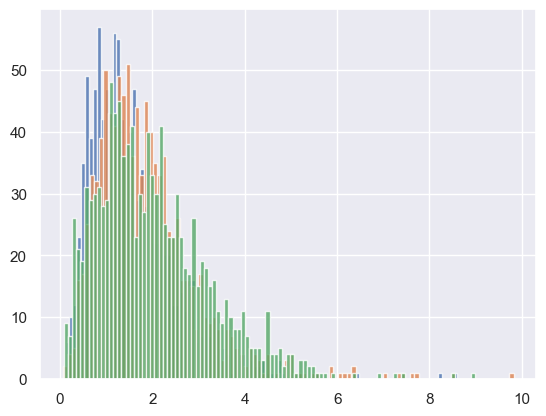

In [169]:
plt.figure()
plt.hist(df_filtered[df_filtered['subjID'] == 1]['isacc_err'], bins = 100, alpha = 0.8)
plt.hist(df_filtered[df_filtered['subjID'] == 3]['isacc_err'], bins = 100, alpha = 0.8)
plt.hist(df_filtered[df_filtered['subjID'] == 23]['isacc_err'], bins = 100, alpha = 0.8)


plt.show()

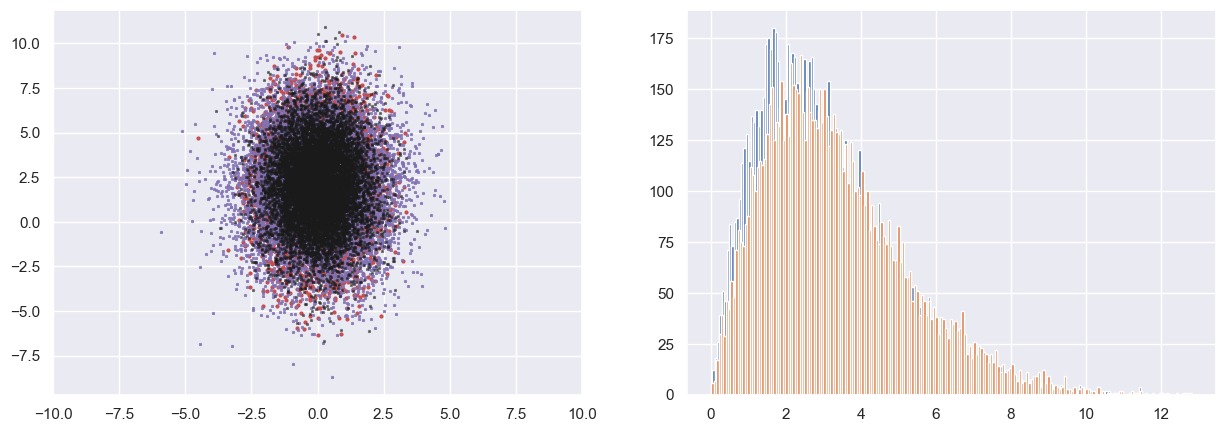

In [200]:
targ = np.random.multivariate_normal([0, 2], [[1, 0], [0, 5]], 10000)
sacc_land = np.random.multivariate_normal([0, 2], [[1, 0], [0, 5]], 10000)
sacc_land_anti = np.random.multivariate_normal([0, 2], [[2, 0], [0, 7]], 10000)

error = np.sqrt((sacc_land[:,0]-targ[:,0])**2+(sacc_land[:,1]-targ[:,1])**2)
error_anti = np.sqrt((sacc_land_anti[:,0]-targ[:,0])**2+(sacc_land_anti[:,1]-targ[:,1])**2)

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].plot(targ[:, 0], targ[:, 1], 'ro', markersize = 2)
axs[0].plot(sacc_land_anti[:, 0], sacc_land_anti[:, 1], 'm*', markersize = 2, alpha = 0.8)
axs[0].plot(sacc_land[:, 0], sacc_land[:, 1], 'k*', markersize = 2, alpha = 0.5)

axs[0].set_xlim([-10, 10])
axs[0].set_xlim([-10, 10])

axs[1].hist(error, bins = 200)
axs[1].hist(error_anti, bins = 200)

plt.show()


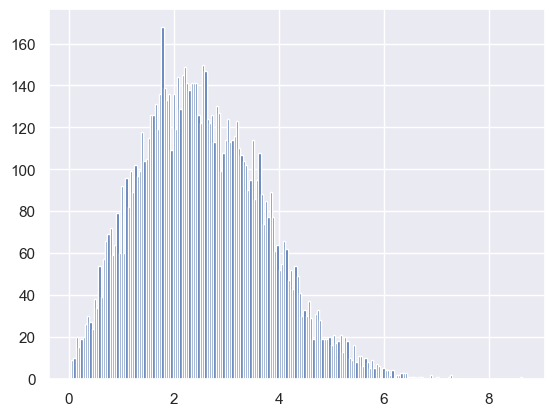

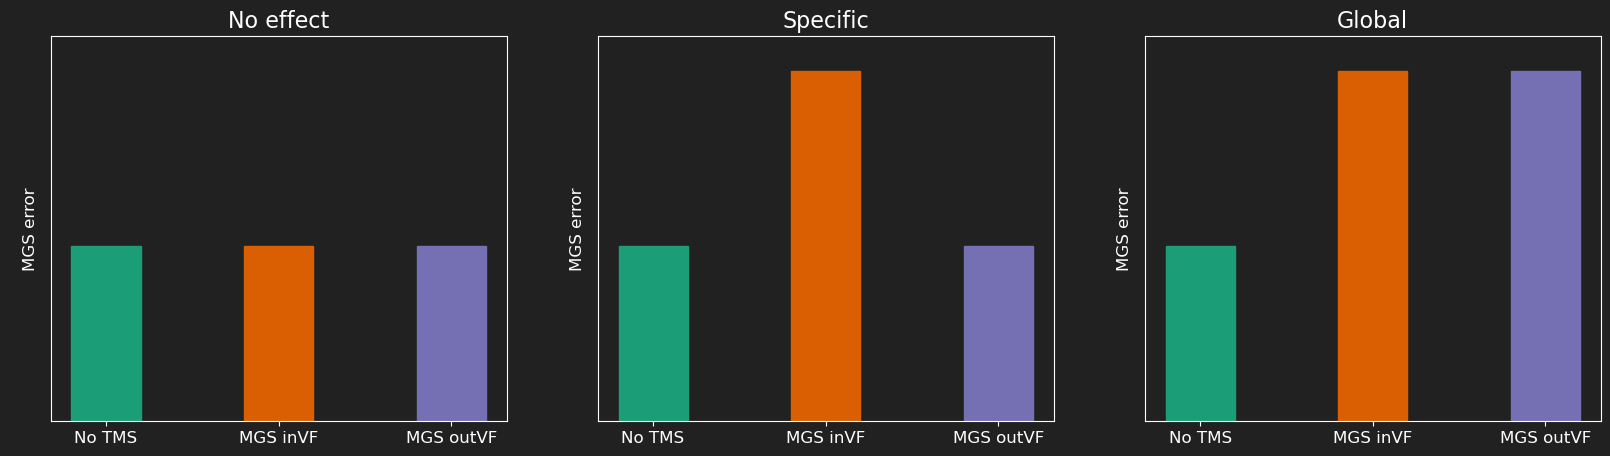

In [5]:
X1 = [0.3, 0.8, 1.3]
bWidth = 0.2
X2 = [round(x + 0.1, 1) for x in X1]
X_sum = [sum(value) for value in zip(X1, X2)]
x_tick_pos = [round(x/2, 2) for x in X1]
x_label_names = ['No TMS', 'MGS inVF', 'MGS outVF']
Y1_equal = [1, 1, 1]
Y1_specific = [1, 2, 1]
Y1_global = [1, 2, 2]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor((33/255, 33/255, 33/255))
axes_fontsize = 12
title_fontsize = 16
for ii in range(3):
    ax[ii].set_facecolor((33/255, 33/255, 33/255))
    ax[ii].spines['bottom'].set_color('white')
    ax[ii].spines['top'].set_color('white')
    ax[ii].spines['left'].set_color('white')
    ax[ii].spines['right'].set_color('white')
    ax[ii].xaxis.label.set_color('white')
    ax[ii].yaxis.label.set_color('white')
    ax[ii].tick_params(axis='x', colors='white')
    ax[ii].tick_params(axis='y', colors=(33/255, 33/255, 33/255))
    ax[ii].set_ylim((0, 2.2))
    ax[ii].set_xticks(X1, x_label_names, fontsize=axes_fontsize)
    ax[ii].set_ylabel('MGS error', fontsize=axes_fontsize, labelpad=-20)
    if ii == 0:
        bars = ax[ii].bar(X1, Y1_equal, width = bWidth)
        ax[ii].set_title('No effect', color = 'white', fontsize=title_fontsize)
    elif ii == 1:
        bars = ax[ii].bar(X1, Y1_specific, width = bWidth)
        ax[ii].set_title('Specific', color = 'white', fontsize=title_fontsize)
    elif ii == 2:
        bars = ax[ii].bar(X1, Y1_global, width = bWidth)
        ax[ii].set_title('Global', color = 'white', fontsize=title_fontsize)
    
    bars[0].set_color("#1B9E77")
    bars[1].set_color("#D95F02")
    bars[2].set_color("#7570B3")
plt.show()

$ALI = \frac{P_{right} - P_{left}}{P_{right} + P_{left}} $

In [6]:
df_filtered.columns

Index(['subjID', 'day', 'tnum', 'rnum', 'istms', 'ispro', 'instimVF',
       'breakfix', 'no_prim_sacc', 'small_sacc', 'large_error', 'rejtrials',
       'TarX', 'TarY', 'isaccX', 'isaccY', 'fsaccX', 'fsaccY', 'isacc_err',
       'fsacc_err', 'isacc_theta_err', 'fsacc_theta_err',
       'corrected_theta_err', 'isacc_radius_err', 'fsacc_radius_err',
       'corrected_radius_err', 'nsacc', 'calib_err', 'isacc_rt', 'fsacc_rt',
       'isacc_peakvel', 'fsacc_peakvel', 'trial_type', 'TMS_condition',
       'TarRadius', 'TarTheta', 'TarX_rotated', 'TarY_rotated', 'isaccRadius',
       'isaccTheta', 'isaccX_rotated', 'isaccY_rotated', 'fsaccRadius',
       'fsaccTheta', 'fsaccX_rotated', 'fsaccY_rotated', 'TarRadius_rotated',
       'TarTheta_rotated', 'isaccRadius_rotated', 'isaccTheta_rotated',
       'fsaccRadius_rotated', 'fsaccTheta_rotated', 'isacc_err_rot',
       'fsacc_err_rot', 'isacc_theta_rot', 'fsacc_theta_rot',
       'isacc_err_rot_normed', 'fsacc_err_rot_normed',
       'isacc

Pro-saccade equivalence point: 341s
Anti-saccade equivalence point: 321s


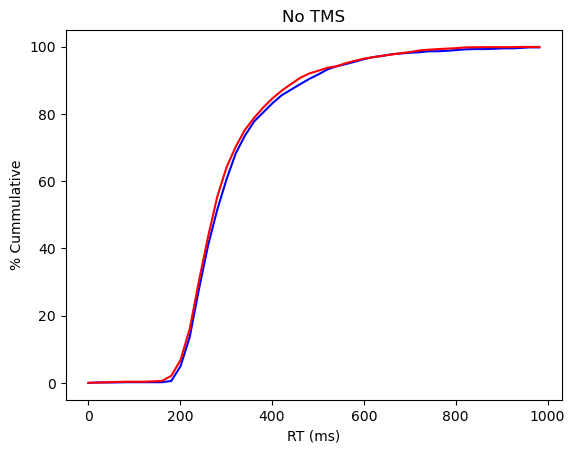

In [7]:
d_good = df_filtered[df_filtered['subjID'] != 18]
pro_rt = d_good[(d_good['ispro']==1) & (d_good['istms']== 0) & (d_good['instimVF'] == 1)]['isacc_rt']
anti_rt = d_good[(d_good['ispro']==0) & (d_good['istms']== 1) & (d_good['instimVF'] == 1)]['isacc_rt']

max_rt = max(np.max(pro_rt), np.max(anti_rt))
#print(max_rt)
nbins = 50
t_bins = np.linspace(0, max_rt, nbins)
t_res = 1/nbins
p_count = np.zeros((nbins, 1))
a_count = np.zeros((nbins, 1))
for ii in range(nbins):
    p_count[ii] = len(np.where((t_bins[ii]<pro_rt) & (pro_rt<t_bins[ii]+t_res))[0])
    a_count[ii] = len(np.where((t_bins[ii]<anti_rt) & (anti_rt<t_bins[ii]+t_res))[0])
p_count = np.cumsum(p_count)/len(pro_rt) * 100
a_count = np.cumsum(a_count)/len(anti_rt) * 100
print('Pro-saccade equivalence point: ' + str(int(round(t_bins[np.where(p_count < 75)[0][-1]]*1000, 0))) + 's')
print('Anti-saccade equivalence point: ' + str(int(round(t_bins[np.where(a_count < 75)[0][-1]]*1000, 0))) + 's')

plt.figure()
plt.plot(t_bins*1000, p_count, 'b-')
plt.plot(t_bins*1000, a_count, 'r-')
plt.xlabel('RT (ms)')
plt.ylabel('% Cummulative')
plt.title('No TMS')
plt.show()

0.9209460010825203


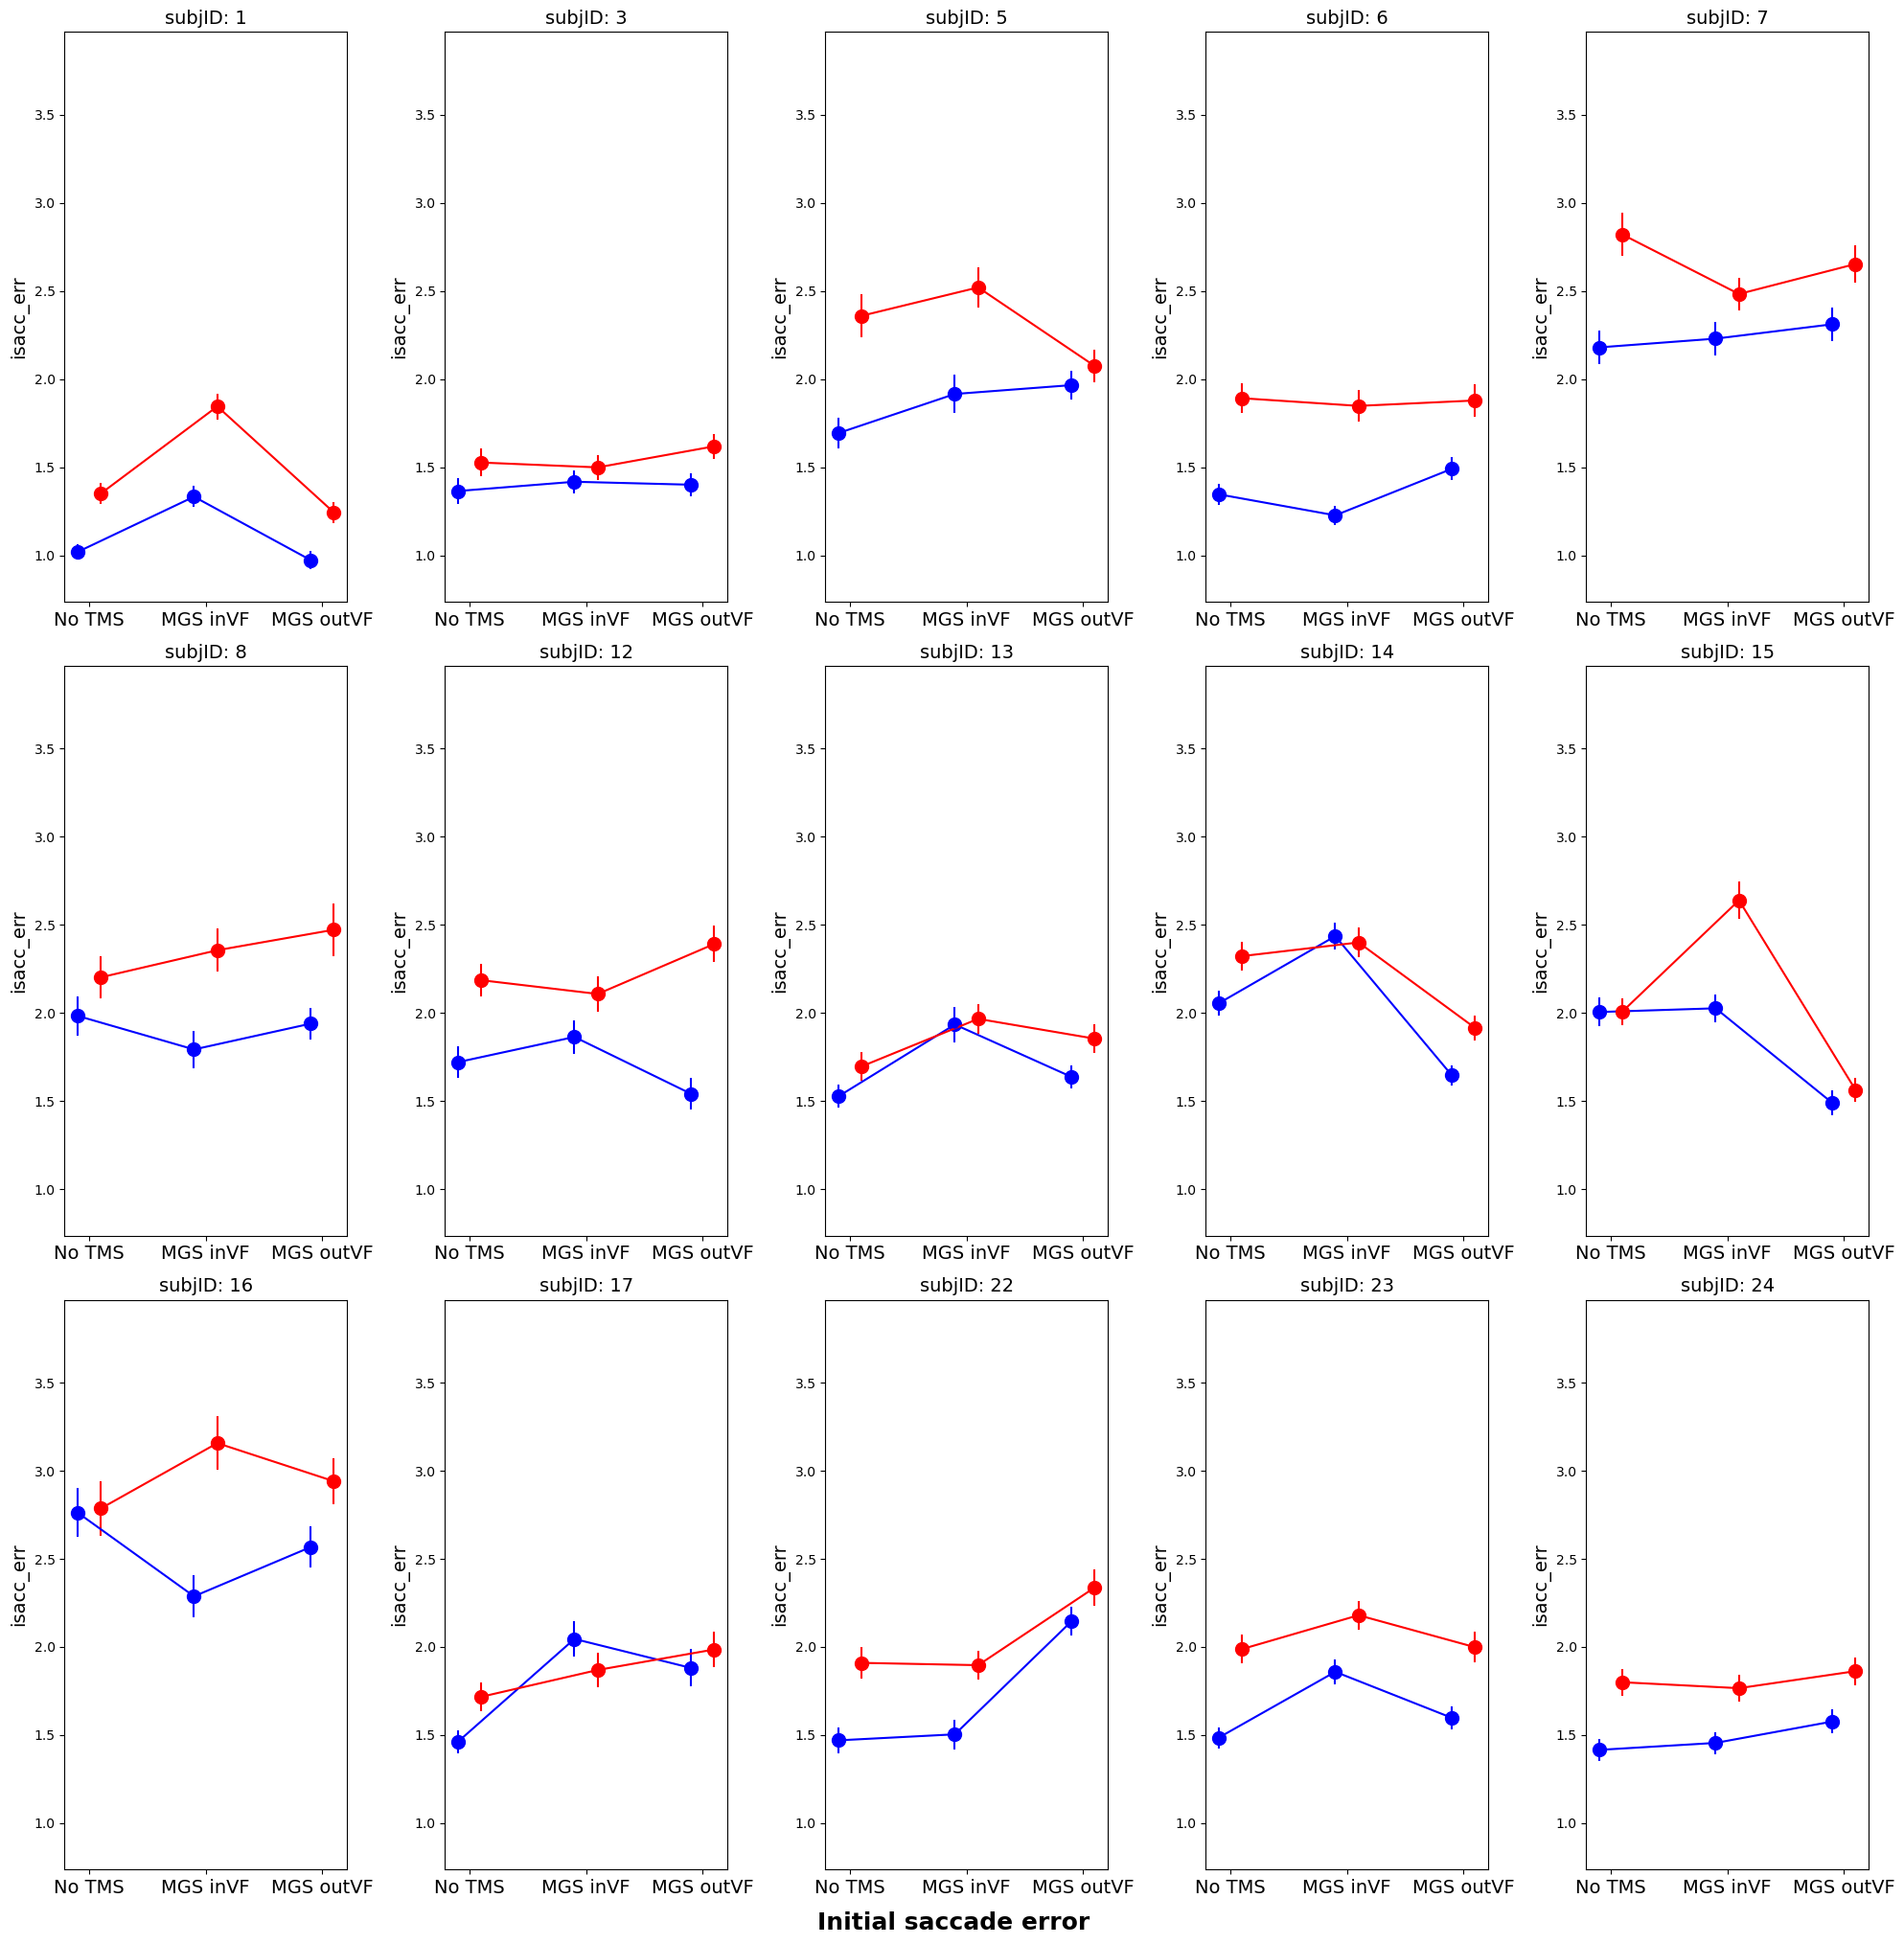

In [8]:
subject_wise_error_plot(df_filtered[df_filtered['subjID'] != 18], 'isacc_err', normalizer = False, indiv_summary = True, remove_outliers = True)

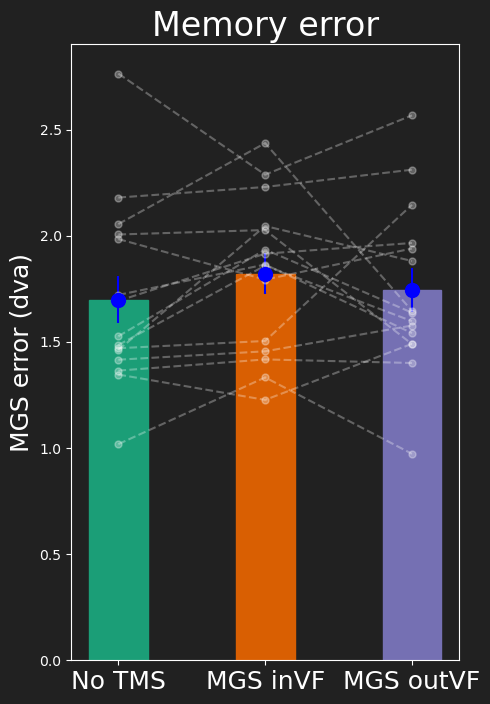

In [9]:
subject_wise_error_plot(df_filtered[df_filtered['subjID'] != 18], 'isacc_err', normalizer = False, indiv_summary = False, remove_outliers = True)

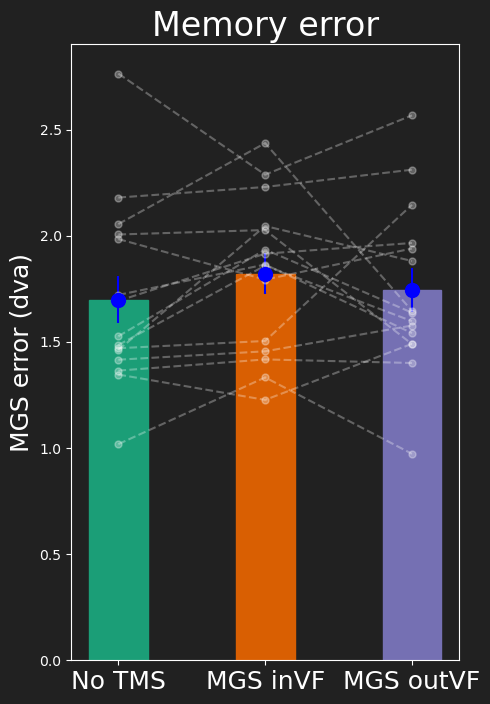

In [13]:
subject_wise_error_plot(df_filtered[df_filtered['subjID'] != 18], 'isacc_err', normalizer = False, indiv_summary = False, remove_outliers = True)

In [11]:
X1 = [0.3, 0.8, 1.3]
X2 = [round(x + 0.1, 1) for x in X1]
X_sum = [sum(value) for value in zip(X1, X2)]
x_tick_pos = [round(x/2, 2) for x in X_sum]
print(X2, x_tick_pos)

[0.4, 0.9, 1.4] [0.35, 0.85, 1.35]


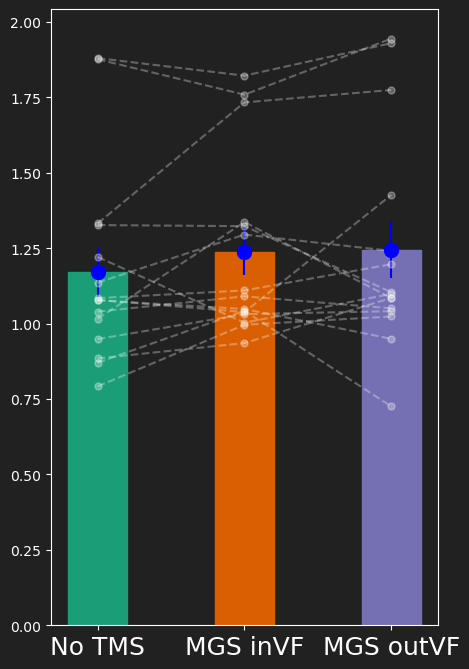

In [12]:
subject_wise_error_plot(df_filtered[df_filtered['subjID'] != 18], 'fsacc_err', normalizer = False, indiv_summary = False, remove_outliers = True)

In [ ]:
df_filtered_good = df_filtered[df_filtered['subjID'] == 1]
plt.figure(figsize=(10, 10))
plt.plot(df_filtered_good['isacc_rt'], np.log(df_filtered_good['isacc_err']), 'r.', markersize=5)
plt.ylabel('Saccade error (dva)')
plt.xlabel('RT (s)')
plt.title('Speed accuracy curve')

In [ ]:
subject_wise_error_plot(df_filtered[df_filtered['subjID'] != 18], 'fsacc_err', normalizer = 'individualized', indiv_summary = True, remove_outliers = False)

In [ ]:
# Summary across conditions for subjects
table_summary = pd.pivot_table(df, values = 'fsacc_err', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.sum(~pd.isnull(x)))
table_summary

In [ ]:
raw_error_summary = pd.pivot_table(df_filtered, values = ['fsacc_err', 'fsacc_theta_err', 'fsacc_radius_err'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
raw_error_summary

In [ ]:
error_summary = pd.pivot_table(df_filtered, values = ['fsacc_theta_rot_normed', 'fsacc_theta_rot'], index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: np.nanmean(np.abs(x)))
error_summary

In [ ]:
df_filtered.describe()
df_filtered.describe(include=object)

In [ ]:
subjIDs = df_filtered['subjID'].unique()
#df_filtered = df_filtered[df_filtered['instimVF'] == 0 ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarX'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarY'], 'r.', markersize = 2)
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccX'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccY'], 'ks', markersize = 2)
    plt.xlim(-25, 25)
    plt.ylim(-20, 20)
    plt.title(str(subjIDs[ii]))

In [ ]:
subjIDs = df_filtered['subjID'].unique()
#df_filtered = df_filtered[(df_filtered['TarTheta'] > -np.pi/2) & (df_filtered['TarTheta'] < np.pi/2) ]
for ii in range(len(subjIDs)):
    plt.figure()
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarX_rotated'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['TarY_rotated'], 'ro', markersize = 4)
    plt.plot(df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccX_rotated'], df_filtered[df_filtered['subjID']==subjIDs[ii]]['fsaccY_rotated'], 'ks', markersize = 2)
    plt.xlim([0, 25])
    plt.ylim([-20, 20])
    plt.title(str(subjIDs[ii]))

In [ ]:
table_summary_hh = pd.pivot_table(df, values = 'TarTheta_rotated', index = ['subjID'], columns = ['TMS_condition', 'ispro'], aggfunc = lambda x: (np.max(x) - np.min(x)) * (180/np.pi))
table_summary_hh

In [ ]:
## Check for any existing trend in data due to eccentricity or angular width
subjIDs = df_filtered['subjID'].unique()
angular_width = np.zeros((len(subjIDs), 2) )
eccs = np.zeros((len(subjIDs),2) )
mean_err = np.zeros((len(subjIDs), 2))
median_err = np.zeros((len(subjIDs), 2))
var_err = np.zeros((len(subjIDs), 2))
range_err = np.zeros((len(subjIDs), 2))
err_met = 'fsacc_theta_err'
for ii in range(len(subjIDs)):
    this_subj_df_pro = df_filtered[(df_filtered['subjID']==subjIDs[ii]) & (df_filtered['TMS_condition']=='No TMS') & (df_filtered['ispro']==1) ]
    this_subj_df_anti = df_filtered[(df_filtered['subjID']==subjIDs[ii]) & (df_filtered['TMS_condition']=='No TMS') & (df_filtered['ispro']==0)]
    mean_err[ii, 0] = np.nanmean(this_subj_df_pro[err_met])
    median_err[ii, 0] = np.nanmedian(this_subj_df_pro[err_met])
    var_err[ii, 0] = np.nanvar(this_subj_df_pro[err_met])
    range_err[ii, 0] = np.nanmax(this_subj_df_pro[err_met]) - np.nanmin(this_subj_df_pro[err_met])
    mean_err[ii, 1] = np.nanmean(this_subj_df_anti[err_met])
    median_err[ii, 1] = np.nanmedian(this_subj_df_anti[err_met])
    var_err[ii, 1] = np.nanvar(this_subj_df_anti[err_met])
    range_err[ii, 1] = np.nanmax(this_subj_df_anti[err_met]) - np.nanmin(this_subj_df_anti[err_met])
    angular_width[ii, 0] = (this_subj_df_pro['TarTheta_rotated'].max() - this_subj_df_pro['TarTheta_rotated'].min()) * (180/np.pi)
    angular_width[ii, 1] = (this_subj_df_anti['TarTheta_rotated'].max() - this_subj_df_anti['TarTheta_rotated'].min()) * (180/np.pi)
    eccs[ii, 0] = this_subj_df_pro['TarRadius'].mean()
    eccs[ii, 1] = this_subj_df_anti['TarRadius'].mean()

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
axs[0, 0].plot(eccs[:, 0], mean_err[:, 0], 'bo')
axs[0, 0].plot(eccs[:, 1], mean_err[:, 1], 'ro')
axs[0, 0].set_xlabel('eccentricity')
axs[0, 0].set_ylabel('mean err')

axs[0, 1].plot(eccs[:, 0], median_err[:, 0], 'bo')
axs[0, 1].plot(eccs[:, 1], median_err[:, 1], 'ro')
axs[0, 1].set_xlabel('eccentricity')
axs[0, 1].set_ylabel('median err')

axs[0, 2].plot(eccs[:, 0], var_err[:, 0], 'bo')
axs[0, 2].plot(eccs[:, 1], var_err[:, 1], 'ro')
axs[0, 2].set_xlabel('eccentricity')
axs[0, 2].set_ylabel('var err')

axs[0, 3].plot(eccs[:, 0], range_err[:, 0], 'bo')
axs[0, 3].plot(eccs[:, 1], range_err[:, 1], 'ro')
axs[0, 3].set_xlabel('eccentricity')
axs[0, 3].set_ylabel('range err')

axs[1, 0].plot(angular_width[:, 0], mean_err[:, 0], 'bo')
axs[1, 0].plot(angular_width[:, 1], mean_err[:, 1], 'ro')
axs[1, 0].set_xlabel('angular_width')
axs[1, 0].set_ylabel('mean err')

axs[1, 1].plot(angular_width[:, 0], median_err[:, 0], 'bo')
axs[1, 1].plot(angular_width[:, 1], median_err[:, 1], 'ro')
axs[1, 1].set_xlabel('angular_width')
axs[1, 1].set_ylabel('median err')

axs[1, 2].plot(angular_width[:, 0], var_err[:, 0], 'bo')
axs[1, 2].plot(angular_width[:, 1], var_err[:, 1], 'ro')
axs[1, 2].set_xlabel('angular_width')
axs[1, 2].set_ylabel('var err')

axs[1, 3].plot(angular_width[:, 0], range_err[:, 0], 'bo')
axs[1, 3].plot(angular_width[:, 1], range_err[:, 1], 'ro')
axs[1, 3].set_xlabel('angular_width')
axs[1, 3].set_ylabel('range err')
plt.show()


Control condition is pro saccades outside VF, where the target and the saccade goal are both located outside the TMS VF. Hence we are interested in seeing if there is a modulation of behavior with respect to this condition. \
Let the errors be: [pNo, pIn, pOut, aNo, aIn, aOut], where pNo = pro saccades with No TMS, pIn = pro saccades in TMS VF, pOut =  pro saccades outside TMS VF, aNo = anti saccades with No TMS, aIn = anti saccades in TMS VF, aOut = anti saccades outside TMS VF. \
The goal is to compare pNo and pIn to pOut.  \
$\therefore error_m = \frac{|pX - pOut|}{pOut} $, where X = No, In, Out \
Similarly, we are interested in comparing aNo and aIn with aOut. and therefore, modulated error for anti-saccades would be: \
$error_m = \frac{|aX - aOut|}{aOut} $, where X = No, In, Out \
However, this negates the obvious difference between anti and pro saccades. Therefore, anti-saccades need to be modulated with the subject-wise baseline difference between anti and pro saccad errors. Hence, the modified formula becomes: \
$error_m = \frac{|aX - aOut|}{aOut} + (aOut - pOut)$, where X = No, In, Out \


Look at raw voltages to remove ERP
NAN out TMS locked pulse and set it to mean of activity before and after.

In [ ]:
df_filtered.columns

In [ ]:
N1 = [1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]
N1[4]

In [ ]:
subjIDs = df_filtered['subjID'].unique()
for ii in range(len(subjIDs)):
   subject_wise_error_plot(df_filtered[df_filtered['subjID'] == subjIDs[ii]], 'isacc_err', False)

subject_wise_error_plot(df_filtered[(df_filtered['subjID'] != 18) & (df_filtered['subjID'] != 8)], 'isacc_err', False)
subject_wise_error_plot(df_filtered, 'isacc_err', False)

In [ ]:
subjIDs = df_filtered['subjID'].unique()
for ii in range(len(subjIDs)):
   subject_wise_error_plot(df_filtered[df_filtered['subjID'] == subjIDs[ii]], 'isacc_rt', False)

subject_wise_error_plot(df_filtered[(df_filtered['subjID'] != 18) & (df_filtered['subjID'] != 8)], 'isacc_rt', False)
subject_wise_error_plot(df_filtered, 'isacc_rt', False)

In [ ]:
subjIDs = df['subjID'].unique()
max_ax = 25
for ss in range(len(subjIDs)):
    subj_df =  df[df['subjID']==subjIDs[ss]]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], 'k*', markersize = 2)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([-max_ax, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([-max_ax, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([-max_ax, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([-max_ax, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([-max_ax, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([-max_ax, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()
    

In [ ]:
from scipy.stats import circmean
r = np.linspace(8, 12, 1000)
r_sacc = np.linspace(12, 8, 1000)
theta_rang = np.linspace(-np.pi, np.pi, 1000)
theta_sacc = np.linspace(np.pi, -np.pi, 1000)
x = r * np.cos(theta_rang)
y = r * np.sin(theta_rang)
x_sacc = r_sacc * np.cos(theta_sacc)
y_sacc = r_sacc * np.sin(theta_sacc)
raw_error = np.sqrt((x-x_sacc)**2+(y-y_sacc)**2)

mean_target = circmean(theta_rang, high=np.pi, low=-np.pi)
this_angle = -1*mean_target
#radial_error = np.max(r) - r
#radial_error_sacc = np.max(r) - r_sacc
rotation_matrix = np.array([[np.cos(this_angle), -np.sin(this_angle)],
                                    [np.sin(this_angle), np.cos(this_angle)]])

x_temp = x #+ radial_error * np.cos(theta_rang)
y_temp = y #+ radial_error * np.sin(theta_rang)
input_target = np.vstack((x_temp, y_temp))
rotated_target = np.dot(rotation_matrix, input_target)
x_rot = rotated_target[0]
y_rot = rotated_target[1]

x_sacc_temp = x_sacc #+ radial_error_sacc * np.cos(theta_sacc)
y_sacc_temp = y_sacc #+ radial_error_sacc * np.sin(theta_sacc)
input_sacc = np.vstack((x_sacc_temp, y_sacc_temp))
rotated_sacc = np.dot(rotation_matrix, input_sacc)
x_sacc_rot = rotated_sacc[0]
y_sacc_rot = rotated_sacc[1]

rot_error = np.sqrt((x_rot-x_sacc_rot)**2+(y_rot-y_sacc_rot)**2)

theta_targ_estim = np.arctan2(y, x)
theta_targ_rot_estim = np.arctan2(y_rot, x_rot)
plt.figure()
plt.plot(x, y, 'ro')
plt.plot(x_sacc, y_sacc, 'ks', markersize = 2)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()

plt.figure()
plt.plot(x_rot, y_rot, 'ro')
plt.plot(x_sacc_rot, y_sacc_rot, 'ks', markersize = 2)
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.show()


In [ ]:
plt.plot(raw_error, rot_error, 'ks', markersize = 2)
plt.plot(np.linspace(0, 25, 100), np.linspace(0, 25, 100), 'mo', markersize =2)
#plt.xlim([0, 5])
#plt.ylim([0, 5])
plt.show()

In [ ]:
plt.plot(theta_targ_estim, theta_targ_rot_estim, 'ks', markersize = 2)
#plt.plot(np.linspace(0, 25, 100), np.linspace(0, 25, 100), 'mo', markersize =2)
#plt.xlim([0, 5])
#plt.ylim([0, 5])
plt.show()

In [ ]:
subjIDs = df['subjID'].unique()
max_ax = 25
nbins = 70
for ss in range(len(subjIDs)):
    subj_df =  df[(df['subjID']==subjIDs[ss]) & (df['rejtrials']!=1)]
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
    plt.suptitle(subjIDs[ss])
    axes[0, 0].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 0].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[0, 1].hist2d(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[0, 1].plot(subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='No TMS') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[1, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[1, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[1, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS intoVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    
    axes[2, 0].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 0].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 1)]['TarY_rotated'], 'ro', markersize = 2)
    axes[2, 1].hist2d(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['isaccY_rotated'], bins = nbins, range = [[-max_ax, max_ax], [-max_ax, max_ax]], density=False)
    axes[2, 1].plot(subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] ==0)]['TarX_rotated'], subj_df[(subj_df['TMS_condition']=='TMS outVF') & (subj_df['ispro'] == 0)]['TarY_rotated'], 'ro', markersize = 2)
    

    axes[0, 0].set_xlim([0, max_ax])
    axes[0, 0].set_ylim([-max_ax, max_ax])
    axes[0, 1].set_xlim([0, max_ax])
    axes[0, 1].set_ylim([-max_ax, max_ax])
    axes[1, 0].set_xlim([0, max_ax])
    axes[1, 0].set_ylim([-max_ax, max_ax])
    axes[1, 1].set_xlim([0, max_ax])
    axes[1, 1].set_ylim([-max_ax, max_ax])
    axes[2, 0].set_xlim([0, max_ax])
    axes[2, 0].set_ylim([-max_ax, max_ax])
    axes[2, 1].set_xlim([0, max_ax])
    axes[2, 1].set_ylim([-max_ax, max_ax])

    axes[0, 0].set_box_aspect(1)
    axes[0, 1].set_box_aspect(1)
    axes[1, 0].set_box_aspect(1)
    axes[1, 1].set_box_aspect(1)
    axes[2, 0].set_box_aspect(1)
    axes[2, 1].set_box_aspect(1)

    axes[0, 0].set_title('No TMS & pro')
    axes[0, 1].set_title('No TMS & anti')
    axes[1, 0].set_title('TMS intoVF & pro')
    axes[1, 1].set_title('TMS intoVF & anti')
    axes[2, 0].set_title('TMS outVF & pro')
    axes[2, 1].set_title('TMS outVF & anti')
    plt.show()

In [ ]:
df_filtered['fsacc_err'] = np.sqrt((df_filtered['fsaccX'] - df_filtered['TarX'])**2 + (df_filtered['fsaccY'] - df_filtered['TarY'])**2)

In [ ]:
quick_visualization(df_filtered)

In [ ]:
distribution_plots(df_filtered)